### 1.라이브러리 불러오기

In [1]:
import warnings

In [2]:
warnings.filterwarnings(action="ignore")

In [3]:
import pandas as pd
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from tensorflow import keras
%matplotlib inline

### 2. 데이터 불러오기 및 분리

In [4]:
traindir = "../images/cat_dog/datasets/train"
testdir = "../images/cat_dog/datasets/test"

In [5]:
IMG_SIZE = 50

In [6]:
def data_load (rootdir, in_img_size, ):
    imageList = []
    labelList = []
    IMG_SIZE = in_img_size
    categories = os.listdir(rootdir)
    # 폴더 순환
    for i in range (0, len(categories)):
        labelPath = os.path.join(rootdir,categories[i])
        imagePath = os.listdir(labelPath)
        # 이미지 순환
        for j in range(0, len(imagePath)):
            imageFullPath = os.path.join(labelPath, imagePath[j])
            try:
                baseImg = cv2.imread(imageFullPath, cv2.IMREAD_GRAYSCALE)
                ### 1. 이미지 사이즈 변경
                refinedImg = cv2.resize(baseImg, (IMG_SIZE,IMG_SIZE))
                imageList.append(refinedImg)
                labelList.append(i)
            except Exception as e:
                print(e, imageFullPath)
                pass

    imageArray = np.array(imageList)
    labelArray = np.array(labelList)
    
    
    return imageArray, labelArray

In [7]:
## use of application

In [8]:
train_x, train_y = data_load(traindir, IMG_SIZE)
test_x, test_y = data_load(testdir, IMG_SIZE)

In [9]:
print(train_x.shape)
print(train_y.shape)

(20000, 50, 50)
(20000,)


In [10]:
trainingData_features = train_x.reshape(len(train_x), 
                              IMG_SIZE, 
                              IMG_SIZE, 
                              1)
testData_features = test_x.reshape(len(test_x), 
                          IMG_SIZE, 
                          IMG_SIZE, 
                          1)

In [11]:
print(trainingData_features.shape)
print(testData_features.shape)


(20000, 50, 50, 1)
(5000, 50, 50, 1)


In [12]:
trainingData_features_norm = trainingData_features/255.0
testData_features_norm = testData_features/255.0

In [13]:
### 접답지는 softmax랑 결합을 위한 onehot encoding

In [14]:
from tensorflow.keras.utils import to_categorical

In [15]:
trainingData_labels_one = to_categorical(train_y)
testData_labels_one = to_categorical(test_y)

In [16]:
trainingData_labels_one[0]

array([1., 0.], dtype=float32)

### 3. 모델 생성

In [17]:
inputShape = trainingData_features[0].shape
inputShape

(50, 50, 1)

In [18]:
outputShape = len(np.unique(train_y))

In [19]:
from tensorflow.keras import Sequential

In [20]:
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout

In [21]:
# 모델생성 시작
model = Sequential()

In [22]:
model.add(Conv2D(filters=32,
                 kernel_size=3, 
                 padding="same", 
                 activation="relu",
                 input_shape=inputShape))

In [23]:
model.add(MaxPooling2D(pool_size= 2 ))

In [24]:
model.add(Dropout(rate=0.4)) # 사용한 비율을 설정

In [25]:
model.add(Conv2D(filters=32,
                 kernel_size=3, 
                 padding="same", 
                 activation="relu",
                 input_shape=inputShape))

In [26]:
model.add(MaxPooling2D(pool_size= 2 ))

In [27]:
model.add(Flatten())

In [28]:
model.add(Dense(units=outputShape, activation="softmax"))

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 50, 50, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 25, 25, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 25, 25, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 4608)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 9

In [30]:
from tensorflow.keras.utils import plot_model

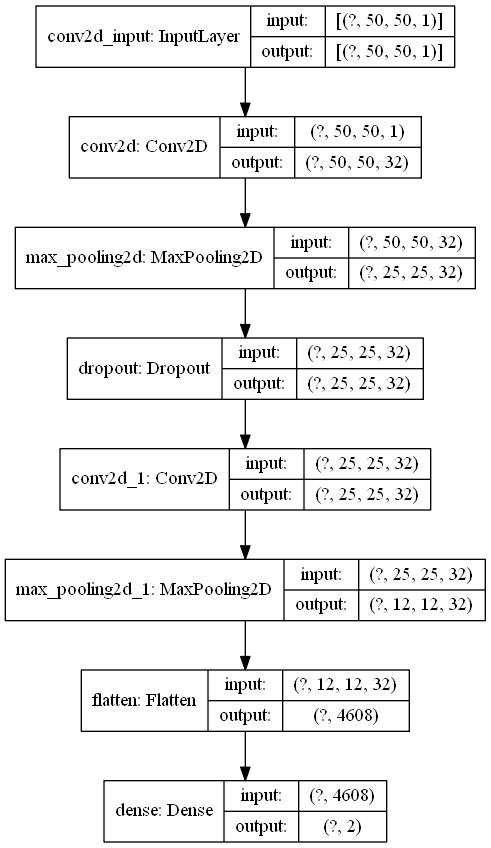

In [31]:
plot_model(model, show_shapes=True)

### 4. 모델 컴파일 (loss, metrics, optimizer)

In [32]:
model.compile(loss=keras.losses.categorical_crossentropy, 
              optimizer= keras.optimizers.Adam(),
              metrics=["accuracy"] )

In [33]:
# model.compile(loss="categorical_crossentropy", 
#               optimizer= "adam",
#               metrics=["accuracy"] )

### 5. 모델 학습(훈련)

In [34]:
epochNo = 5

In [35]:
len(trainingData_features_norm)

20000

In [36]:
33600 / 32

1050.0

In [37]:
model.fit(x=trainingData_features_norm, 
          y=trainingData_labels_one,
          epochs=epochNo,
          batch_size=32,
          validation_data=(testData_features_norm, testData_labels_one) )

Train on 20000 samples, validate on 5000 samples
Epoch 1/5
20000/20000 [==============================] - 35s 2ms/sample - loss: 0.6375 - accuracy: 0.6235 - val_loss: 0.5965 - val_accuracy: 0.6752
Epoch 2/5
20000/20000 [==============================] - 36s 2ms/sample - loss: 0.5635 - accuracy: 0.7117 - val_loss: 0.5565 - val_accuracy: 0.7066
Epoch 3/5
20000/20000 [==============================] - 37s 2ms/sample - loss: 0.5284 - accuracy: 0.7433 - val_loss: 0.5383 - val_accuracy: 0.7270
Epoch 4/5
20000/20000 [==============================] - 36s 2ms/sample - loss: 0.4977 - accuracy: 0.7618 - val_loss: 0.5006 - val_accuracy: 0.7598
Epoch 5/5
20000/20000 [==============================] - 36s 2ms/sample - loss: 0.4829 - accuracy: 0.7724 - val_loss: 0.4824 - val_accuracy: 0.7724


In [38]:
categories = os.listdir(traindir)

In [39]:
def refineImage(testImg):
    ## 테스트 이미지 컬러 변경
    ## 컬러이미지 -> 회색톤으로 변경
    img_gray= cv2.cvtColor(testImg,cv2.COLOR_RGB2GRAY)

    ## 사이즈 조정
    img_resize = cv2.resize(img_gray,(IMG_SIZE,IMG_SIZE))

    ## shape 변경
    img_shape = img_resize.reshape(1,IMG_SIZE,IMG_SIZE,1)

    img_shape.shape

    ## 정규화
    img_norm = img_shape/255.0
    
    return img_norm

In [40]:
import os, shutil

test_image_path='../images/cat_dog/input/test/'
copy_output_path = '../images/cat_dog/output/testresult'

In [41]:
##이미지 파일 명 불러오기
images = os.listdir(test_image_path)

In [42]:
for i in range(0, 10):
    try:
        #각 이미지 path생성
        #이미지 불러오기
        #이미지 정제하기 (회색톤, 사이즈조정, shape 조정)
        #이미지 예측하기
        #예측한 결과값 활용하여 폴더 생성하기
        #폴더 내 파일 복사
        image_path_full = os.path.join(test_image_path,images[i])
        testData = cv2.imread(image_path_full, cv2.IMREAD_COLOR)
        refinedImageOne = refineImage(testData)

        category_path = categories[np.argmax(model.predict(refinedImageOne))]
        target_copy_paths=os.path.join(copy_output_path,category_path)

        if not os.path.isdir(target_copy_paths):
            os.makedirs(target_copy_paths)

        shutil.copy2(image_path_full, target_copy_paths)
    except Exception as e:
        print(e)